# SaaS Company Sales Analysis

This notebook performs exploratory data analysis (EDA) on the sales data of a Software as a Service (SaaS) company, in the specific Amazon AWS, from 2020 to 2023. [Click here to see the dataset on Kaggle](https://www.kaggle.com/datasets/7750efed2f8651cf0e0ac9d161d36b9916dada803898bb585dbf67b6bd9d8c23).

If we find some linear relationship with at least one of the sales metrics in the data, we will perform linear regression to predict sales.

## Table of Contents

1. [Import Libraries](#import-libraries)
2. [Explore & Clean the Data](#explore--clean--the-data)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_cleaned = pd.read_pickle('SaaS_sales_data_cleaned.pkl')

## Explore & Clean  The Data

### Load the dataset

In [2]:
# Load the data
data = pd.read_csv('SaaS-Sales.csv')

# Convert the data to a pickle file so it can be loaded later on without re-loading the csv file.
data.to_pickle('SaaS_sales_dataset.pkl')

# Show the first few values
data.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


### Get some basic information from the data

Now we need to get some basic information on the dataset to asses the data types and non-null values for every cplumn.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Date Key      9994 non-null   int64  
 4   Contact Name  9994 non-null   object 
 5   Country       9994 non-null   object 
 6   City          9994 non-null   object 
 7   Region        9994 non-null   object 
 8   Subregion     9994 non-null   object 
 9   Customer      9994 non-null   object 
 10  Customer ID   9994 non-null   int64  
 11  Industry      9994 non-null   object 
 12  Segment       9994 non-null   object 
 13  Product       9994 non-null   object 
 14  License       9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null   float64
 18  Profit        9994 non-null 

Wonderful, it looks like each column is in the data type it should be in (even if we'd like to have the date in a datetime format), and also every column as the same amount of non-null values, which is a sign indicating that probably we won't find any null value.

### Check for missing values and duplicates

Even if probably there won't be any missing value, we still better double check.

Text(0.5, 1.0, 'Total Missing values')

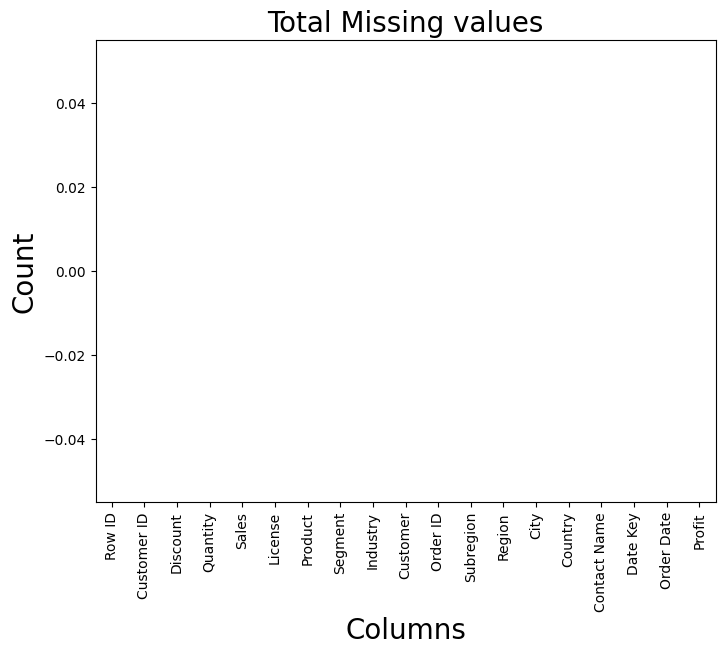

In [9]:
total_missing = data.isnull().sum().sort_values(ascending=False)
total_missing_select = total_missing
total_missing_select.plot(kind='bar', figsize = (8,6), fontsize = 10)

plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize  = 20)
plt.title("Total Missing values", fontsize = 20)

Amazing, as suspected, there are no missing values in our dataset!

Before looking at the descriptive statitstics, we need also to check for duplicate values, which my skew the distribution of the data. We are going to use "Row ID" as unique identifier of each order, which according to the author of the dataset is "A unique identifier for each transaction."

In [11]:
duplicate = data[data.duplicated(['Row ID'], keep=False)]
duplicate.count()

Row ID          0
Order ID        0
Order Date      0
Date Key        0
Contact Name    0
Country         0
City            0
Region          0
Subregion       0
Customer        0
Customer ID     0
Industry        0
Segment         0
Product         0
License         0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

There is no duplicate Row ID in the dataset. However, let's check more thoroughly for potential duplicates. There are many entries with the same Order ID, Date Key, Contact Name, Country, CIty, Region, etc., which is not a problem because multiple products might be sold in a single deal. However, it would be a red flag if the Product was the same too.

In [13]:
duplicate_multiple_attributes = data[data.duplicated(['Order ID', 'Order Date', 'Date Key', 'Product'], keep=False)]
duplicate.count()

Row ID          0
Order ID        0
Order Date      0
Date Key        0
Contact Name    0
Country         0
City            0
Region          0
Subregion       0
Customer        0
Customer ID     0
Industry        0
Segment         0
Product         0
License         0
Sales           0
Quantity        0
Discount        0
Profit          0
dtype: int64

Great, there are 0 red flags, so so it's safe to say that there are not duplicates in this dataset.

### Convert "Order Date"

Even if we don't need it right now, we should convert the Order Date from 'object' type to 'datetime' type. The date has a "MMDDYYYY" format(Dtype "object"), whereas the Date Key has a "YYYYMMDD" format (Dtype "int64"). We should convert one of the two and remove the other to avoid redundancy.

Converting "object" Dtypes into datetime is generally easier, so we are going to convert "Order Date" and drop "Date Key".

In [23]:
# Convert to datetime
data['Order Date Datetime'] = pd.to_datetime(data['Order Date'], format='%m/%d/%Y')
data.to_pickle('SaaS_sales_dataset.pkl')

# Print the first five rows to check if the conversion was successful
data.head(5)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit,Order Date Datetime
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136,2022-11-09
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,2022-11-09
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714,2022-06-13
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,2021-10-11
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164,2021-10-11


The data looks good, now let's assess the Dtypes again.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Row ID               9994 non-null   int64         
 1   Order ID             9994 non-null   object        
 2   Order Date           9994 non-null   object        
 3   Date Key             9994 non-null   int64         
 4   Contact Name         9994 non-null   object        
 5   Country              9994 non-null   object        
 6   City                 9994 non-null   object        
 7   Region               9994 non-null   object        
 8   Subregion            9994 non-null   object        
 9   Customer             9994 non-null   object        
 10  Customer ID          9994 non-null   int64         
 11  Industry             9994 non-null   object        
 12  Segment              9994 non-null   object        
 13  Product              9994 non-nul

You can see a 20th column with the date in the datetime format. Now we can remove the rendundat date columns.

In [36]:
data_cleaned = data.drop(['Order Date', 'Date Key'], axis=1)
data_cleaned.to_pickle('SaaS_sales_data_cleaned.pkl')
data_cleaned.head()

,Row ID,Order ID,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit,Order Date Datetime
0,1,EMEA-2022-152156,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136,2022-11-09
1,2,EMEA-2022-152156,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820,2022-11-09
2,3,AMER-2022-138688,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714,2022-06-13
3,4,EMEA-2021-108966,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310,2021-10-11
4,5,EMEA-2021-108966,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164,2021-10-11


### Describe the data

Now that we have seen the basic info and the shape of the dataset, we want see some basic descriptive statistics of the numerical values in the dataset.

In [37]:
data_cleaned.describe()

,Row ID,Customer ID,Sales,Quantity,Discount,Profit,Order Date Datetime
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994
mean,4997.500000,1049.771963,229.858001,3.789574,0.156203,28.656896,2022-05-01 00:07:12.259355648
min,1.000000,1001.000000,0.444000,1.000000,0.000000,-6599.978000,2020-01-04 00:00:00
25%,2499.250000,1024.000000,17.280000,2.000000,0.000000,1.728750,2021-05-23 00:00:00
50%,4997.500000,1049.000000,54.490000,3.000000,0.200000,8.666500,2022-06-27 00:00:00
75%,7495.750000,1076.000000,209.940000,5.000000,0.200000,29.364000,2023-05-15 00:00:00
max,9994.000000,1101.000000,22638.480000,14.000000,0.800000,8399.976000,2023-12-31 00:00:00
std,2885.163629,29.719388,623.245101,2.225110,0.206452,234.260108,NaN


We can easily see that AWS has beeen profitable in the selected date range. However, we can also see that the mean of both sales and profitability are very close to the 75th percentile, and this means that there there are fewer bigger deals that contribute to the majority of sales; this is further confirmed but the extremely high standard deviation of these two attributes. On the other hand, the quantity of sales look more normally distributed, being the mean and 50th percentile much closer. Last but not least, there seems to be low variability in the discount rate, with a standard deviation of 20.65% and a mean of 15.62%, also by looking at the 50th and 75th percetiles, which have the same value (20%), we can see that most discounts are of 20%.

Now that we have seen and interpreted the basic descriptive statistics, we should dive deeper and plot the distributions of each of these key attributes.

### Data distributions

In [11]:
# Helper function to plot the distributions
def plot_distribution(value_to_plot, xmin, xlim, value_name):
    plt.figure(figsize=(14, 8))

    # Create histogram
    value_distribution = sns.histplot(value_to_plot, bins=150, kde=False)
    # Even if it will take out some of the precision, we are going to set a number of bins
    # to better see the data

    # Set x-axis to cover the full range of Sales values
    plt.xlim(xmin, xlim)

    # Set y-axis to cover up to the maximum count of occurrences
    plt.ylim(0, value_distribution.get_figure().axes[0].get_ylim()[1])

    # Add titles and labels
    plt.title(f'{value_name} Distribution')
    plt.xlabel('Sales')
    plt.ylabel('Count')

    plt.show()

In [12]:
# Helper function to plot the distributions of two attributes
def plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2):
    plt.figure(figsize=(14, 8))

    # Create histograms
    sns.histplot(value_to_plot1, bins=150, kde=False, color='blue', label=value_name1, alpha=0.6)
    sns.histplot(value_to_plot2, bins=150, kde=False, color='red', label=value_name2, alpha=0.6)

    # Set x-axis to cover the full range of Sales values
    plt.xlim(xmin, xlim)

    # Set y-axis to cover up to the maximum count of occurrences
    plt.ylim(0, plt.gca().get_ylim()[1])

    # Add titles and labels
    plt.title(f'Distribution of {value_name1} and {value_name2}')
    plt.xlabel('Sales')
    plt.ylabel('Count')
    
    # Add a legend to differentiate between the two attributes
    plt.legend()

    plt.show()


In [13]:
# Helper function to plot the distributions
def plot_distribution_no_bins(value_to_plot, xmin, xlim, value_name):
    plt.figure(figsize=(14, 8))

    # Create histogram
    value_distribution = sns.histplot(value_to_plot, kde=False)
    # Even if it will take out some of the precision, we are going to set a number of bins
    # to better see the data

    # Set x-axis to cover the full range of Sales values
    plt.xlim(xmin, xlim)

    # Set y-axis to cover up to the maximum count of occurrences
    plt.ylim(0, value_distribution.get_figure().axes[0].get_ylim()[1])

    # Add titles and labels
    plt.title(f'{value_name} Distribution')
    plt.xlabel('Sales')
    plt.ylabel('Count')

    plt.show()

#### Sales Vs Profit distribution

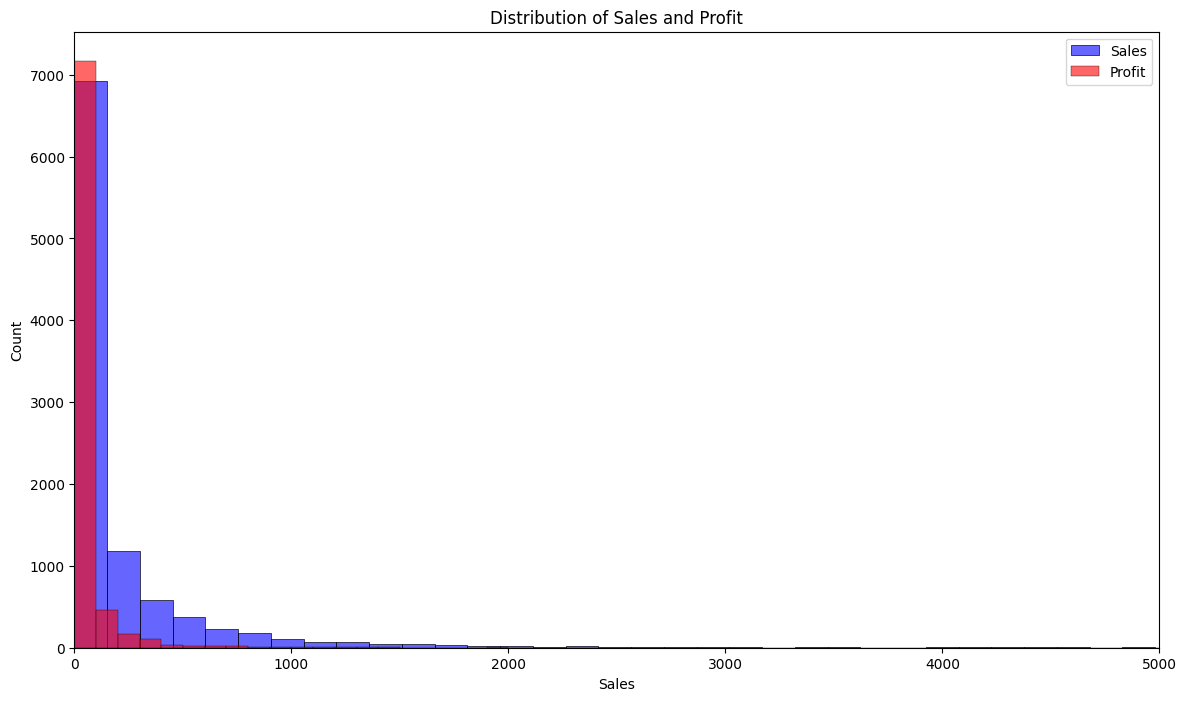

In [124]:
value_to_plot1 = data_cleaned['Sales']
value_to_plot2 = data_cleaned['Profit']

xmin = 0

#Limit the x-axes to the max number of sales visible by naked eye
xlim = 5000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

We can already see the profits and sales distribution are liarly correlated, but if we look at the tale, we cannot see any profit, at list via naked eye.

We'll further limit the max value on the x-axes to zoom in and better look at our values.

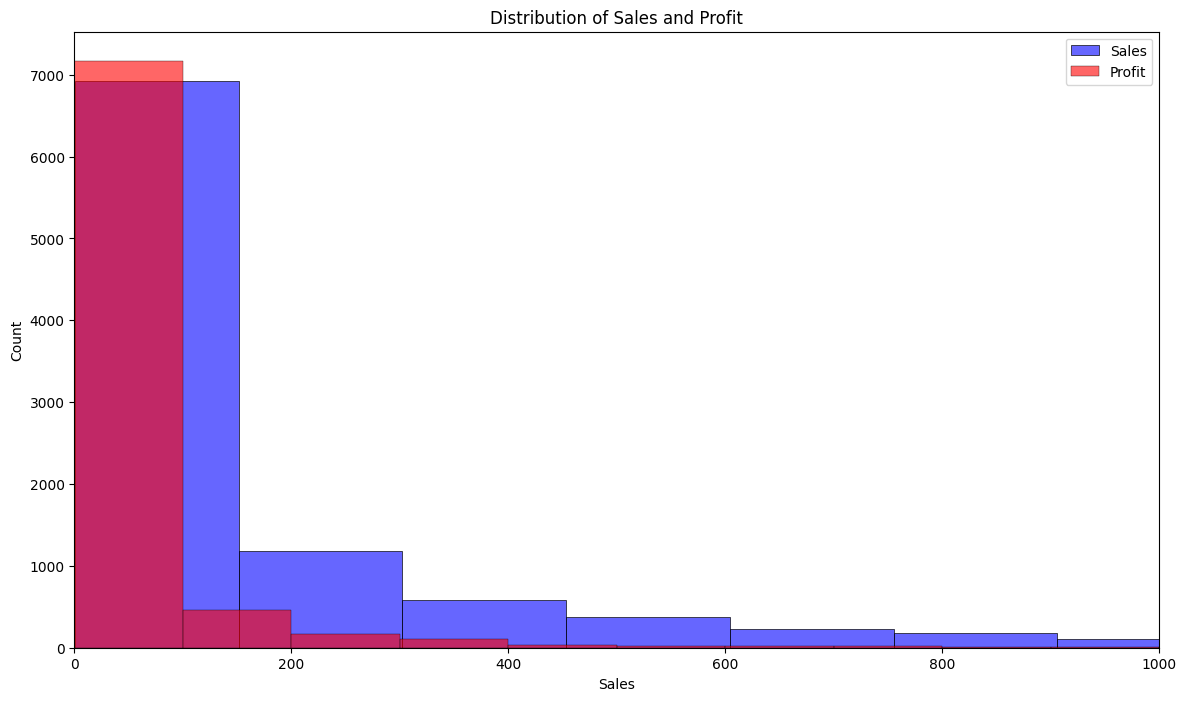

In [27]:
value_to_plot1 = data_cleaned['Sales']
value_to_plot2 = data_cleaned['Profit']

xmin = 0

#Limit the x-axes to the max number of profit visible by naked eye
xlim = 1000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

Here we can see that we have more profits on the low end area (around 0). This is because some small deals result in a loss.

Let's set a new minimum treshold to validate our hypotesis.

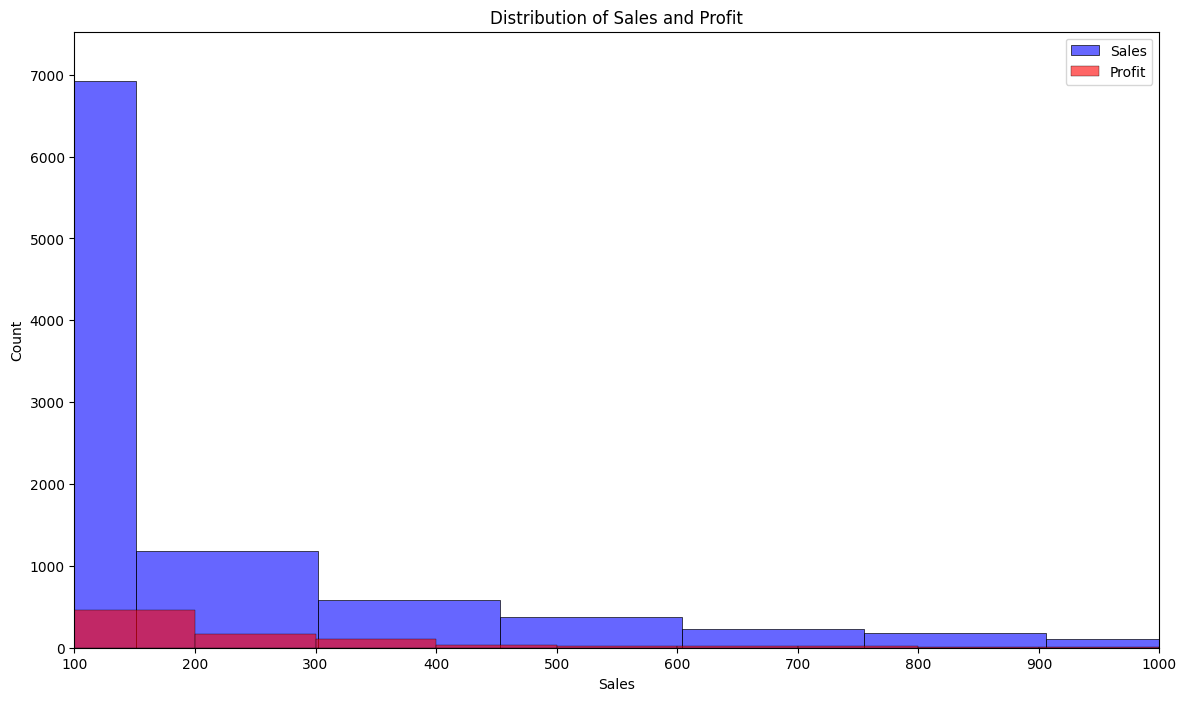

In [127]:
value_to_plot1 = data_cleaned['Sales']
value_to_plot2 = data_cleaned['Profit']

xmin = 100

#Limit the x-axes to the max number of profit visible by naked eye
xlim = 1000

value_name1 = 'Sales'
value_name2 = 'Profit'

plot_distribution_2(value_to_plot1, value_to_plot2, xmin, xlim, value_name1, value_name2)

As we can see, the phenomenon doesn't happen anymore if we move our minimum from the 0-10 area.

#### Sales distribution

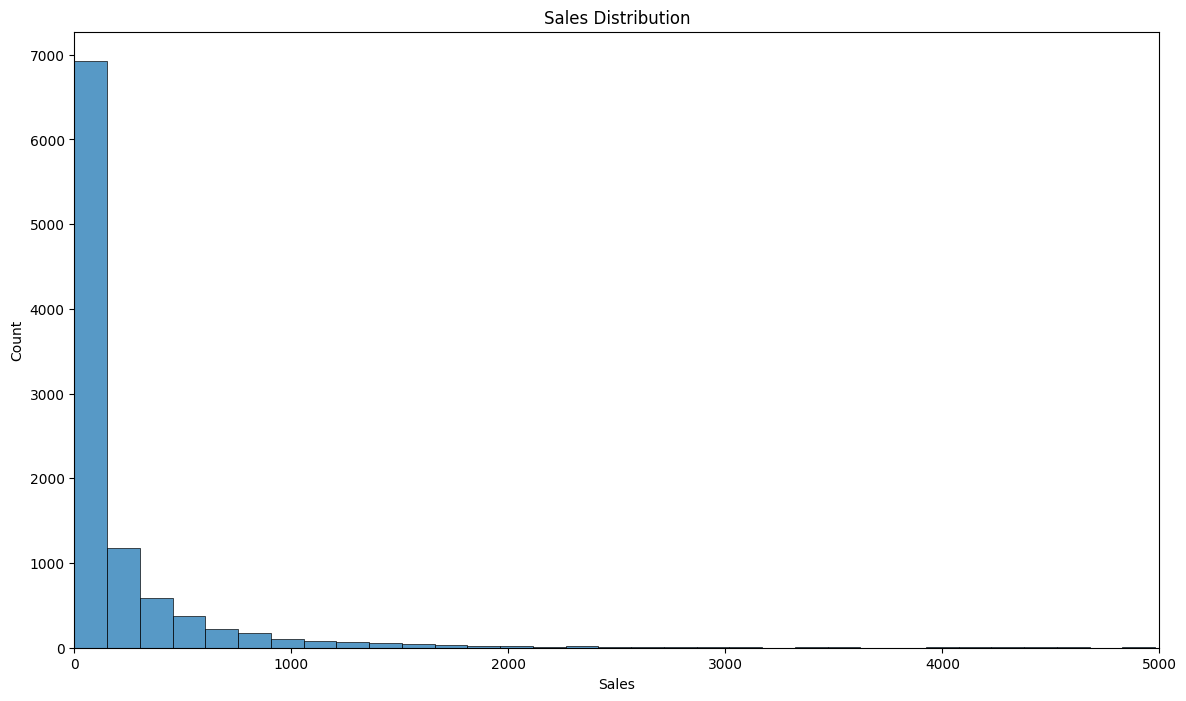

In [31]:
value_to_plot = data_cleaned['Sales']

xmin = 0

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 5000

value_name = 'Sales'

plot_distribution(value_to_plot,xmin, xlim,value_name)

In [3]:
print("Skewness: %f" % data_cleaned['Sales'].skew())

Skewness: 12.972752


Let's zoom into the data.

In [132]:
filtered_data = data_cleaned[data_cleaned['Sales'] > 1000]['Sales']

In [133]:
print(filtered_data.describe())
print(filtered_data.head())

count      468.000000
mean      2115.745897
std       1947.083340
min       1000.020000
25%       1211.596000
50%       1519.419000
75%       2276.615000
max      22638.480000
Name: Sales, dtype: float64
10    1706.184
24    1044.630
27    3083.430
35    1097.544
54    1029.950
Name: Sales, dtype: float64


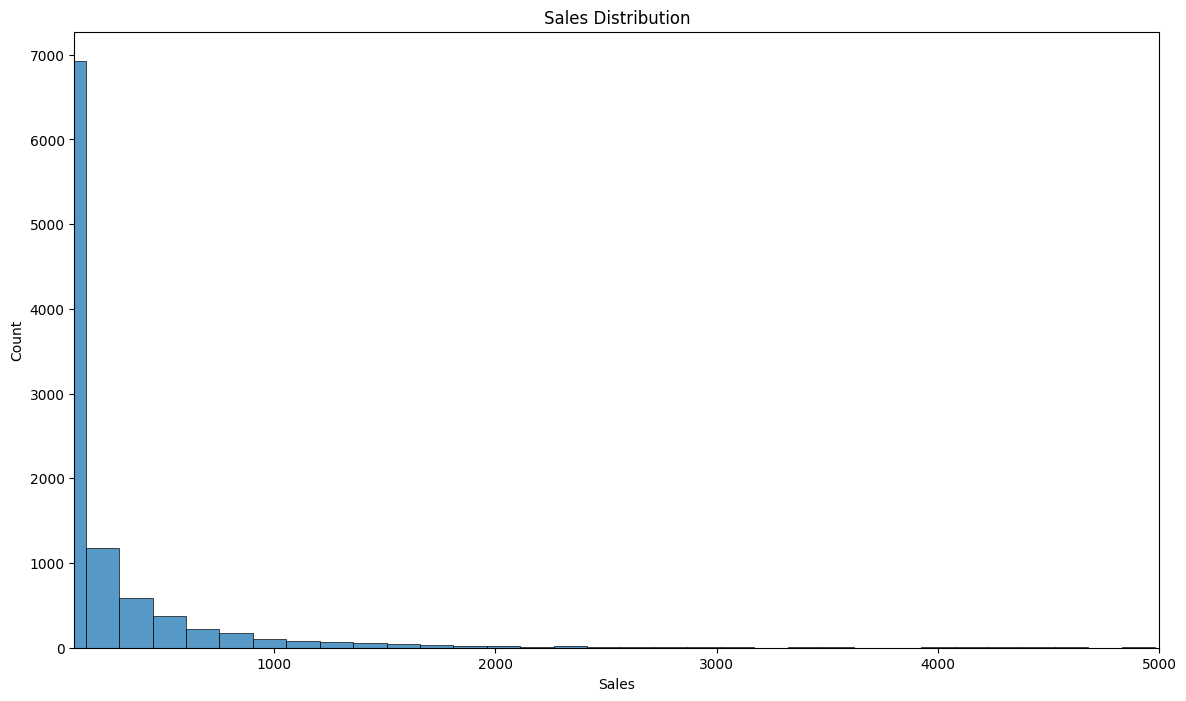

In [134]:
value_to_plot = data_cleaned['Sales']

xmin = 100

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 5000

value_name = 'Sales'

plot_distribution(value_to_plot,xmin,xlim,value_name)

#### Profit distribution

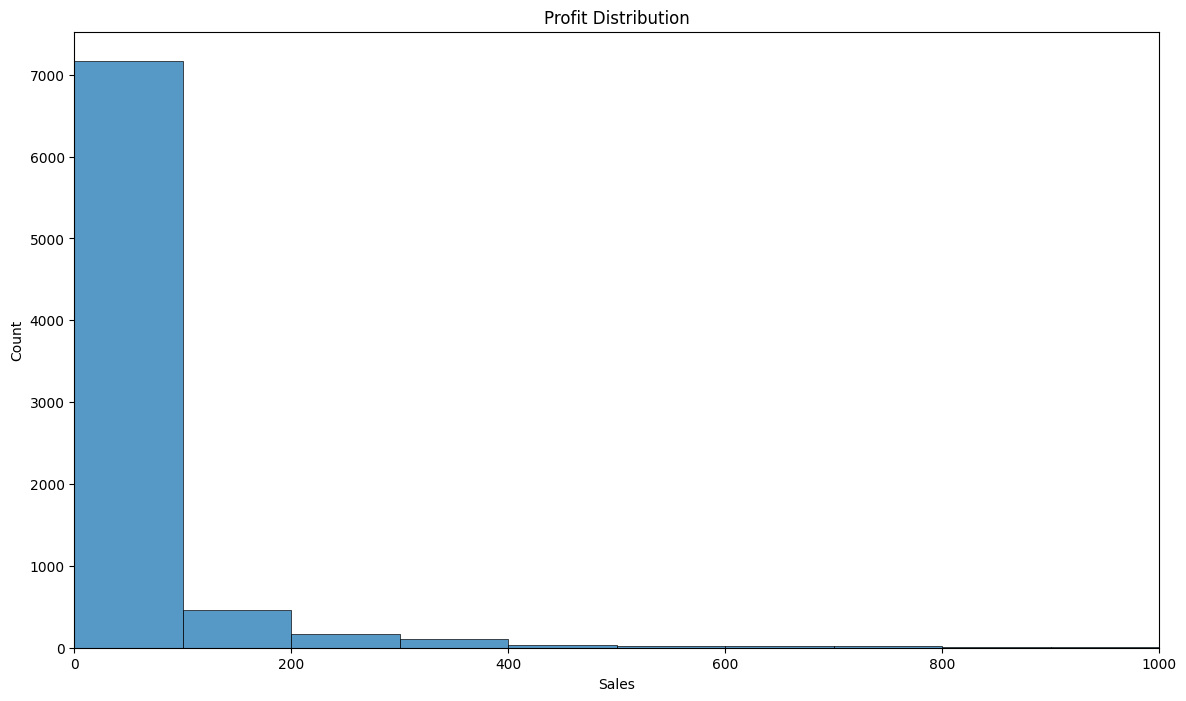

In [129]:
value_to_plot = data_cleaned['Profit']

xmin = 0

#We set a maximum value for the x axis, because there are many impercettible outlayers
#That would make the plot too long
xlim = 1000

value_name = 'Profit'

plot_distribution(value_to_plot,xmin,xlim,value_name)

In [4]:
print("Skewness: %f" % data_cleaned['Profit'].skew())

Skewness: 7.561432


#### Quantity distribution

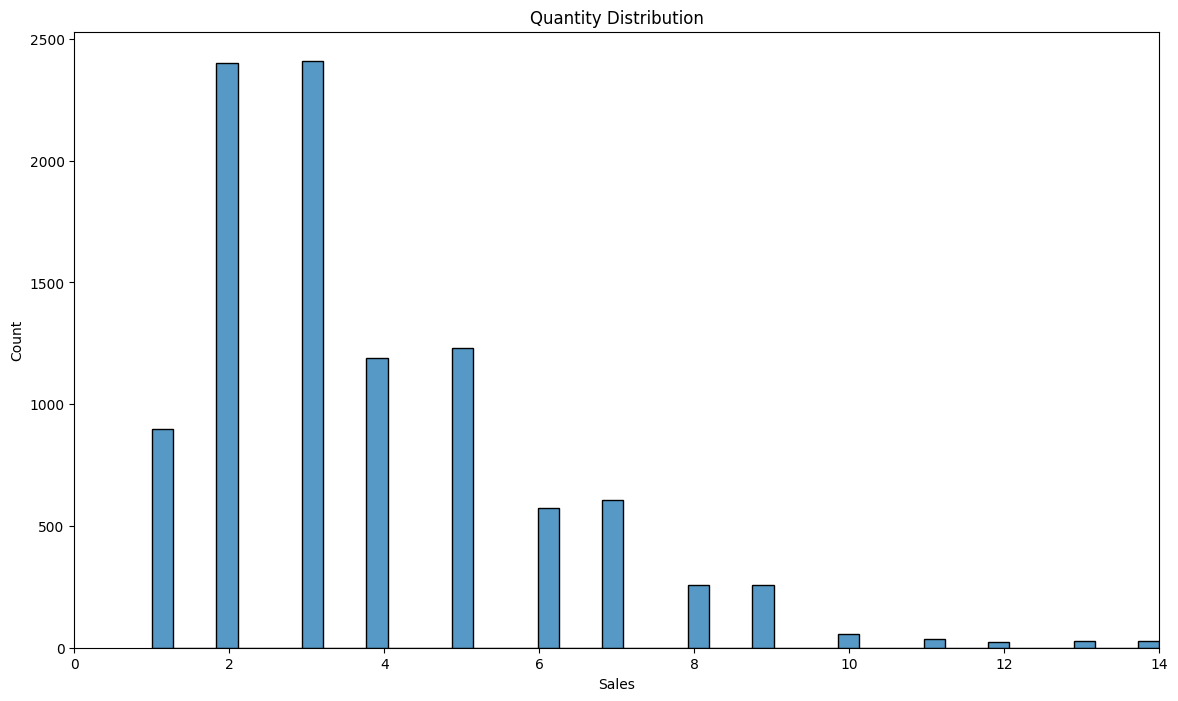

In [34]:
value_to_plot = data_cleaned['Quantity']

xmin = 0
xlim = value_to_plot.max()

value_name = 'Quantity'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

In [5]:
print("Skewness: %f" % data_cleaned['Quantity'].skew())

Skewness: 1.278545


#### Discount distribution

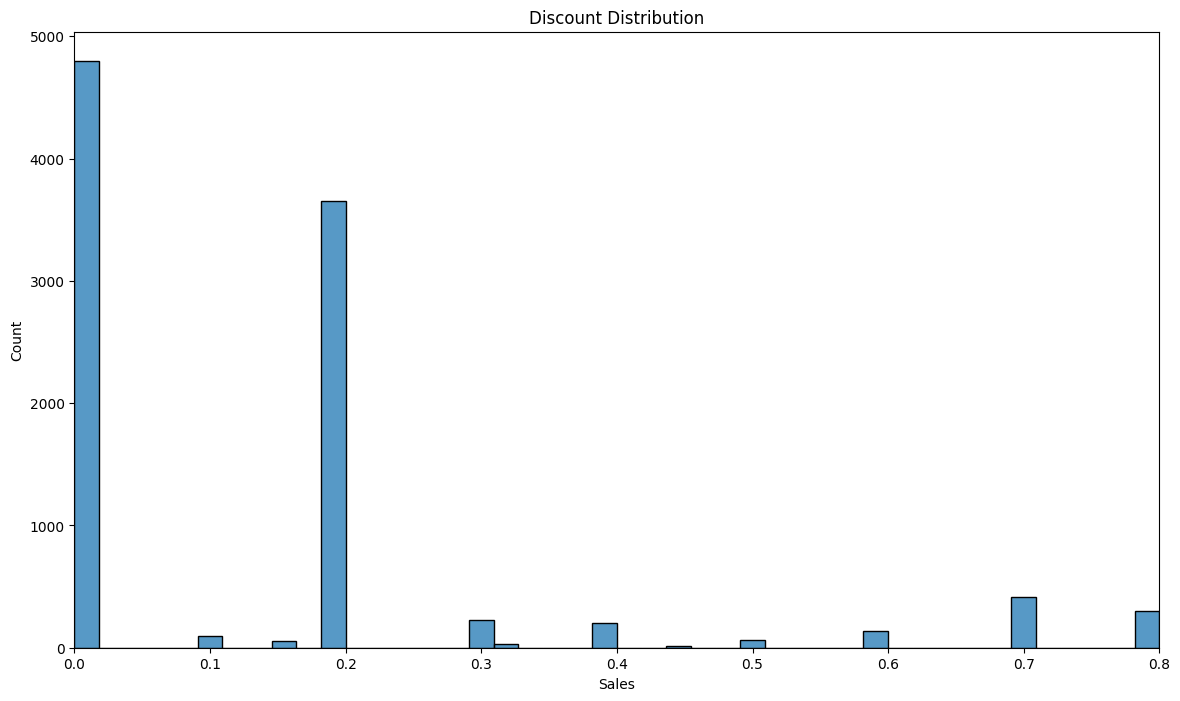

In [35]:
value_to_plot = data_cleaned['Discount']

xmin = 0
xlim = value_to_plot.max()

value_name = 'Discount'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

In [6]:
print("Skewness: %f" % data_cleaned['Discount'].skew())

Skewness: 1.684295


As we can see, the data is too skewed to consider it for linear regression. Therefore, we will probably need to deal with outlyaers. Before doing so, let's try to reduce skewness by log trasforming the data.

### Trasformed data distributions

In [14]:
attributes = ['Sales', 'Profit', 'Quantity', 'Discount']
transformed_data = {}

for attr in attributes:
    shift_value = abs(data_cleaned[attr].min()) + 1
    transformed_data[attr] = np.log(data_cleaned[attr] + shift_value)
    print(f"Skewness of {attr}: %f" % transformed_data[attr].skew())


Skewness of Sales: 0.313661
Skewness of Profit: -83.116332
Skewness of Quantity: 0.369157
Skewness of Discount: 1.316102


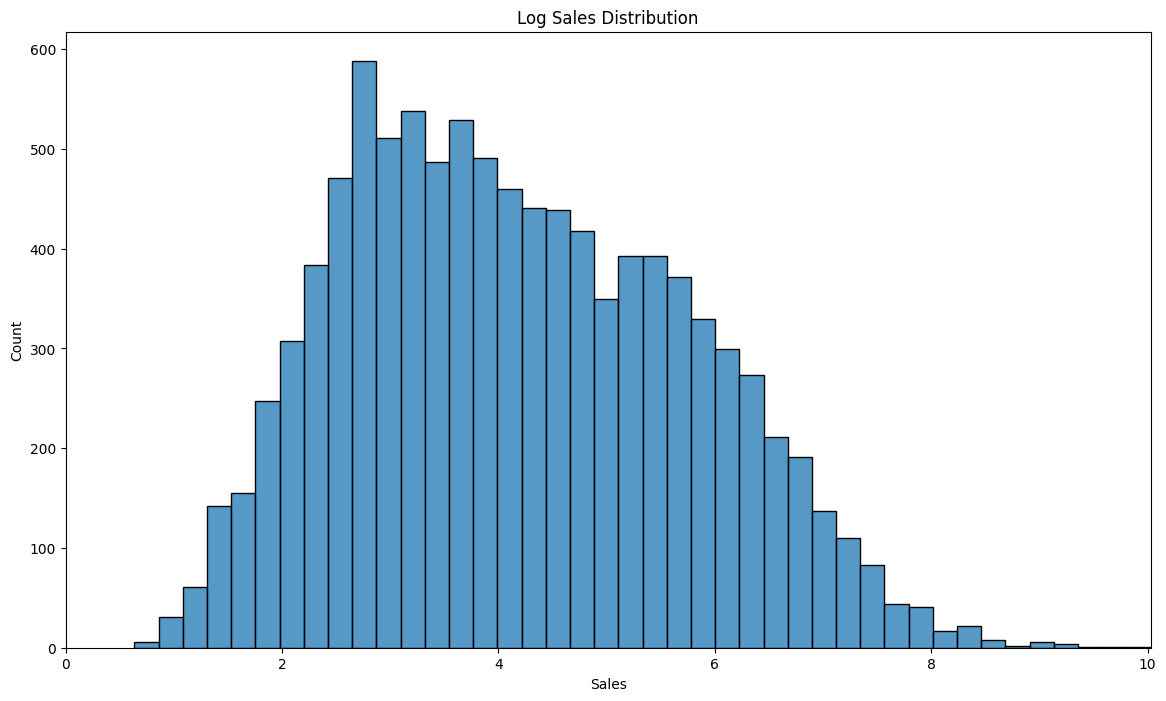

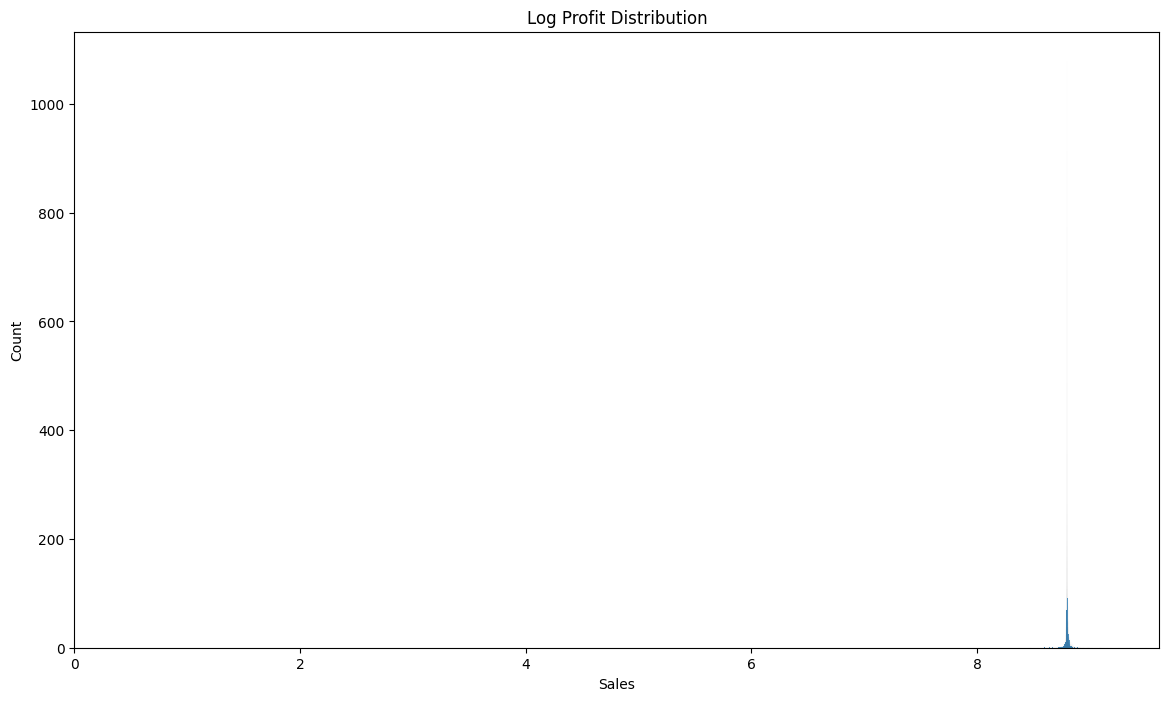

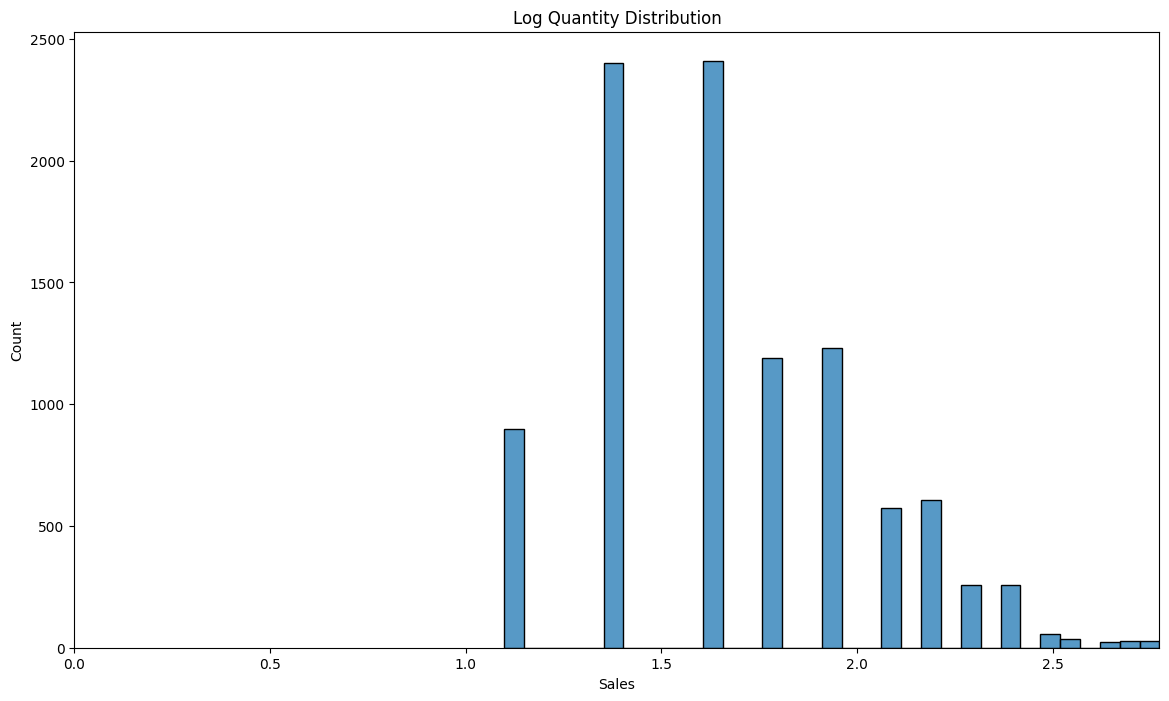

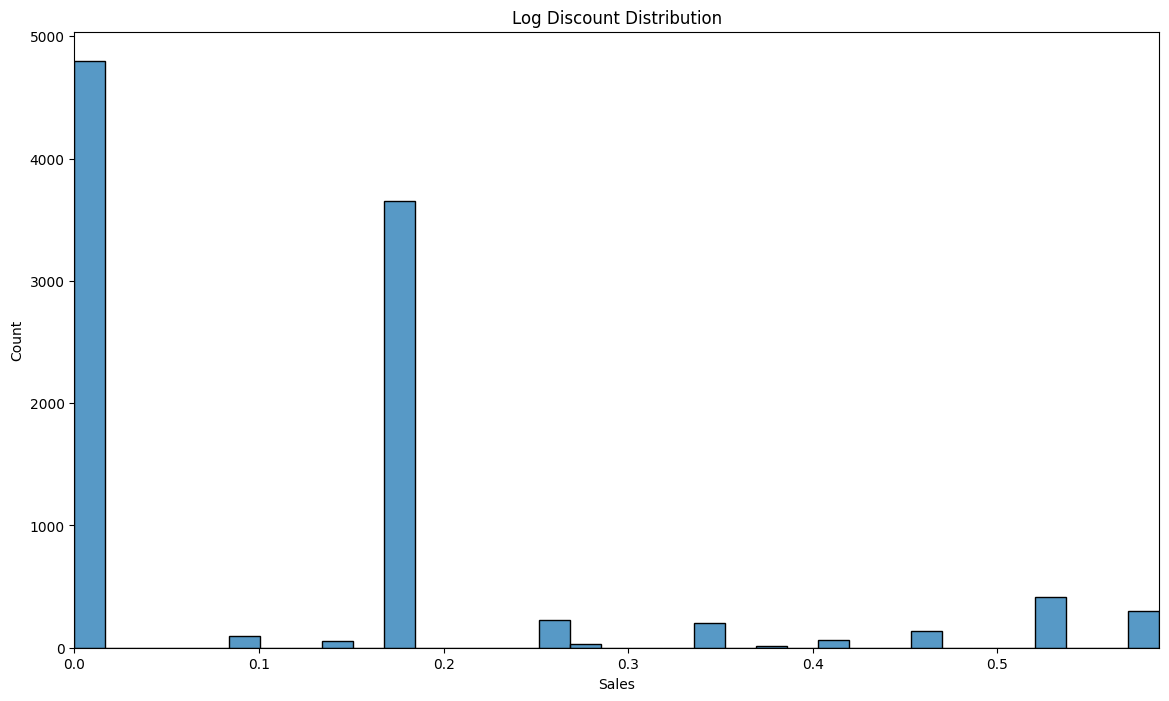

In [15]:
attributes = ['Sales', 'Profit', 'Quantity', 'Discount']

for attr in attributes:
    value_to_plot = transformed_data[attr]

    xmin = 0
    xlim = value_to_plot.max()

    value_name = f'Log {attr}'

    plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

#### Log sales distribution

In [13]:
log_transformed_sales = np.log(data_cleaned['Sales'])
print("Skewness: %f" % log_transformed_sales.skew())

Skewness: 0.188648


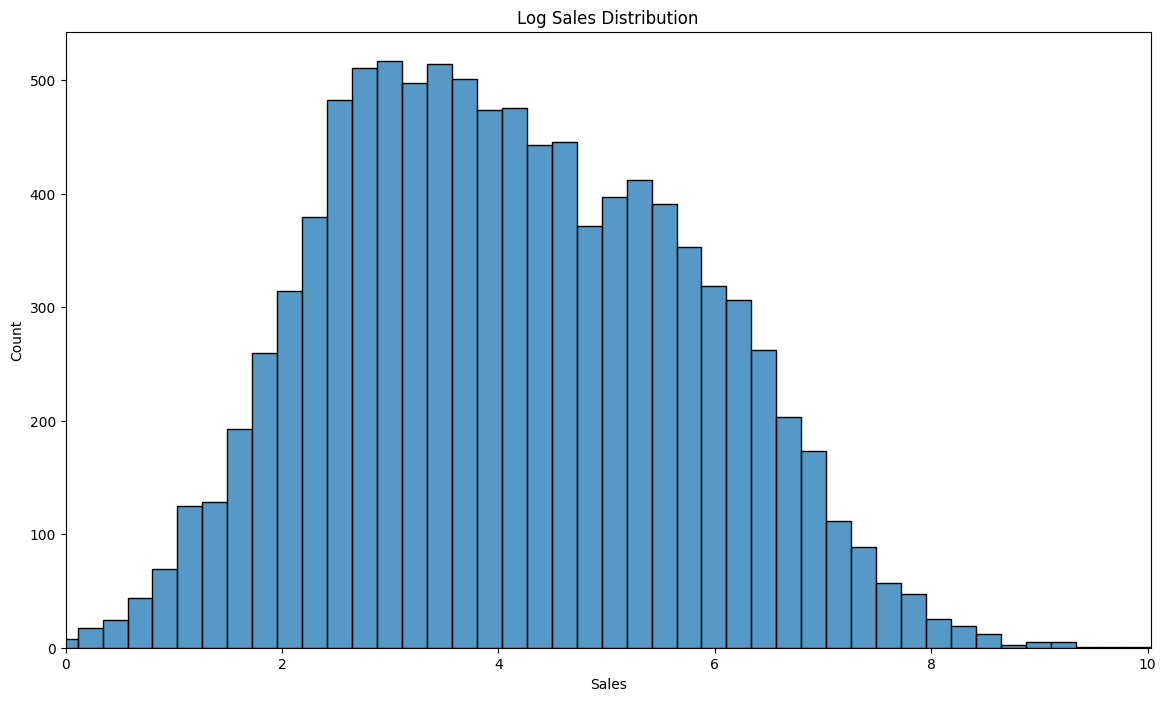

In [36]:
value_to_plot = log_transformed_sales

xmin = 0
xlim = value_to_plot.max()

value_name = 'Log Sales'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

In [8]:
cube_root_transformed_sales = np.cbrt(data_cleaned['Sales'])
print("Skewness: %f" % cube_root_transformed_sales.skew())

Skewness: 1.595959


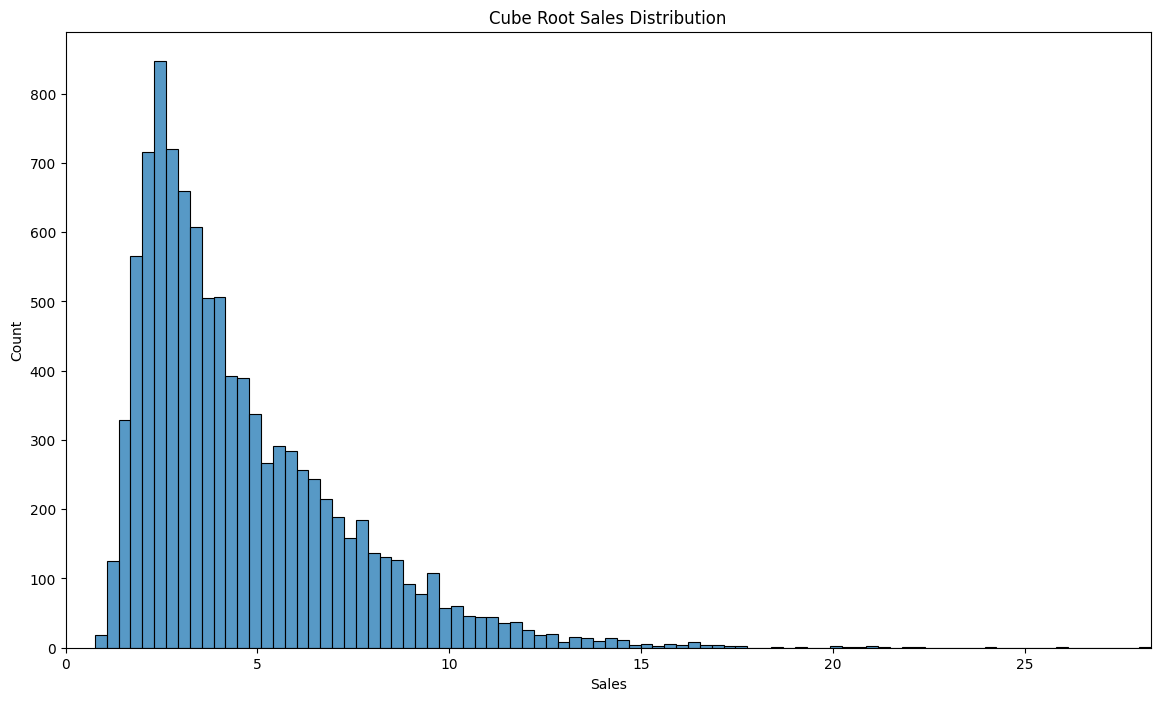

In [13]:
value_to_plot = cube_root_transformed_sales

xmin = 0
xlim = value_to_plot.max()

value_name = 'Cube Root Sales'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

In [ ]:
shift_value = abs(data_cleaned['Discount'].min()) + 1
log_transformed_discount = np.log(data_cleaned['Discount'] + shift_value)


#### Log profit distribution

In [4]:
data_cleaned = pd.read_pickle('SaaS_sales_data_cleaned.pkl')

In [14]:
#Log does not work with negative values, so I need to find an alternative

log_transformed_profit = np.log(data_cleaned['Profit'])
print("Skewness: %f" % log_transformed_profit.skew())

Skewness: nan


In [6]:
cube_root_transformed_profit = np.cbrt(data_cleaned['Profit'])
print("Skewness: %f" % cube_root_transformed_profit.skew())


Skewness: -0.738572


#### Log sales and profit distribution

#### Log quantity distribution

In [16]:
log_transformed_quantity = np.log(data_cleaned['Quantity'])
print("Skewness: %f" % log_transformed_quantity.skew())

Skewness: -0.147863


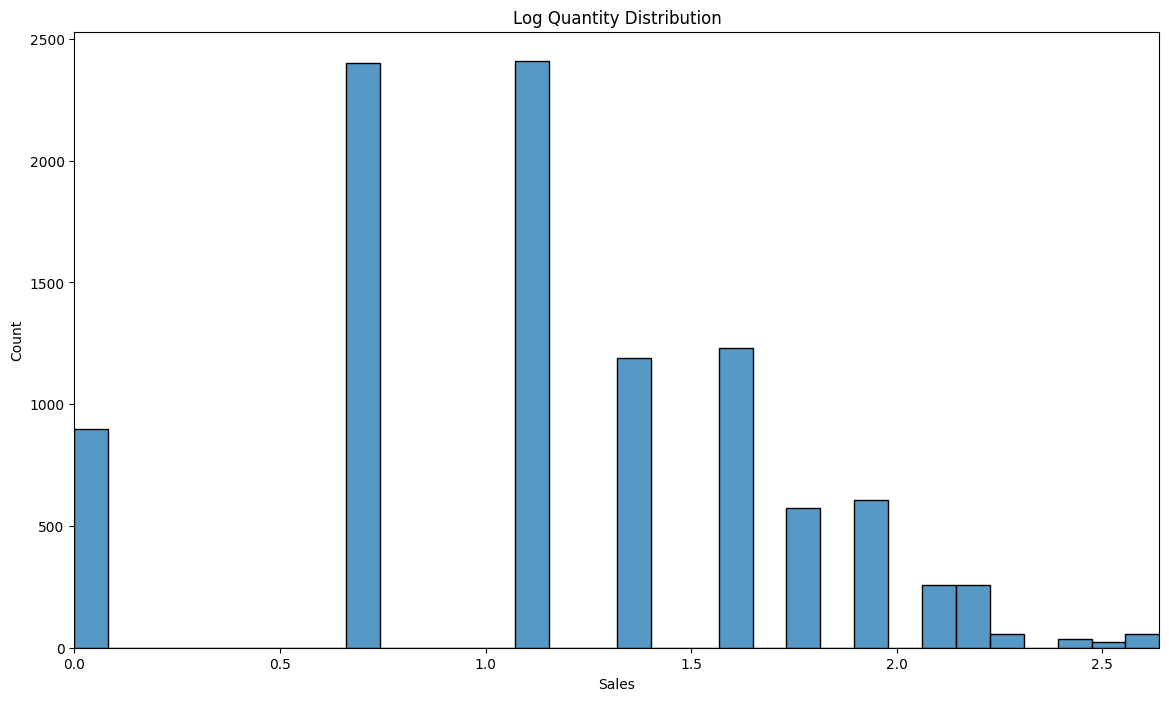

In [37]:
value_to_plot = log_transformed_quantity

xmin = 0
xlim = value_to_plot.max()

value_name = 'Log Quantity'

plot_distribution_no_bins(value_to_plot,xmin,xlim,value_name)

#### Log discount distribution

In [17]:
log_transformed_discount = np.log(data_cleaned['Discount'])
print("Skewness: %f" % log_transformed_discount.skew())

Skewness: nan


C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gabri\AppData\Roaming\Python\Python311\site-packages\pandas\core\nanops.py:1248: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
